# <a id='toc1_'></a>[Анализ датасета и обучение моделей](#toc0_)

- [Анализ датасета и обучение моделей](#toc1_)    
  - [Анализ датасета](#toc1_1_)    
  - [Обучение модели](#toc1_2_)    
  - [Работа модели на реальных данных](#toc1_3_)    
  - [Вывод](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import albumentations as A
from PIL import ImageFile, Image
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    LearningRateMonitor,
    EarlyStopping,
)
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import CometLogger
from sklearn.model_selection import train_test_split
from albumentations.augmentations.geometric.resize import Resize
from albumentations.augmentations.transforms import (
    Normalize,
    RandomBrightnessContrast,
    RandomFog,
)

from src import BuildDatasetImage, LitDataLoader, ModelLight, MultilabelClassifier

ImageFile.LOAD_TRUNCATED_IMAGES = True

seed_everything(42, workers=True)  # за детерминизм
torch.set_float32_matmul_precision("medium")

PATH_FOR_DATA = "data/interim"  # путь к файлам с данными
PATH_FOR_IMAGE = "data/interim/images/"  # путь с изображениям
PATH_FOR_TEST_IMAGE = "data/interim/test_images"  # путь к тестовым изображения

Global seed set to 42


## <a id='toc1_1_'></a>[Анализ датасета](#toc0_)

Посчитаем сколько объектов каждого класса есть в датасете и установим распределение количества объектов на изображениях

In [2]:
train_df = pd.read_csv(os.path.join(PATH_FOR_DATA, "train.csv"))
valid_df = pd.read_csv(os.path.join(PATH_FOR_DATA, "valid.csv"))
test_df = pd.read_csv(os.path.join(PATH_FOR_DATA, "test.csv"))

df = pd.concat([train_df, valid_df]).reset_index(drop=True)
df["object_count"] = df.apply(lambda x: x[1:].sum(), axis=1)

object_count = {}
for key in df.columns[1:]:
    object_count[key] = 0


def counter_object(x):
    x = x.to_dict()
    for key in object_count.keys():
        object_count[key] += x[key]


df.apply(counter_object, axis=1)
print('')

In [3]:
train_df.sample(3)

image  sofa  wardrobe  chair  armchair  table  commode  bed
696  984.jpg   0.0       1.0    0.0       0.0    0.0      1.0  0.0
667  642.jpg   1.0       0.0    1.0       0.0    0.0      0.0  0.0
63   267.jpg   0.0       0.0    0.0       1.0    0.0      0.0  0.0

In [4]:
object_count

{'sofa': 197.0,
 'wardrobe': 115.0,
 'chair': 363.0,
 'armchair': 269.0,
 'table': 324.0,
 'commode': 205.0,
 'bed': 193.0,
 'object_count': 1666.0}

In [5]:
df.object_count.value_counts(normalize=True)

object_count
1.0    0.542458
2.0    0.292707
3.0    0.125874
4.0    0.027972
5.0    0.006993
6.0    0.001998
0.0    0.001998
Name: proportion, dtype: float64

Как видно из представленных данных:
- на изображениях представленно всего 7 классов и 1666 объектов, из них:
    - диванов 197; 
    - шкафов 115; 
    - стульев 363; 
    - кресел 269; 
    - столов 324;
    - кроватей 193.
- чаще всего на изображениях имеется 1 класс (55%), по 2 и 3 класса 29 и 12 процентов соответственно.

Исходные изображения выглядят примерно так:

/tmp/ipykernel_1423074/2287399466.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


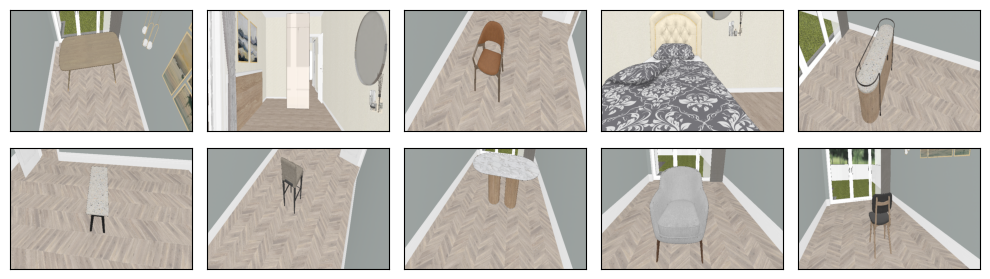

In [6]:
fig = plt.figure(figsize=(10, 3))
name_list = df["image"].to_list()
for index in range(10):
    name = name_list[index]
    img = Image.open(os.path.join(PATH_FOR_IMAGE, name))
    fig.add_subplot(2, 5, index + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

При аугментации изображений, будут использованы разные виды повоторов и туман, изминение контрастности (вероятность аугментации 0.6 и у каждой аугментации будет своя вероятность). На модель будут подаваться примерно такие изображения:

/tmp/ipykernel_1423074/1552153699.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


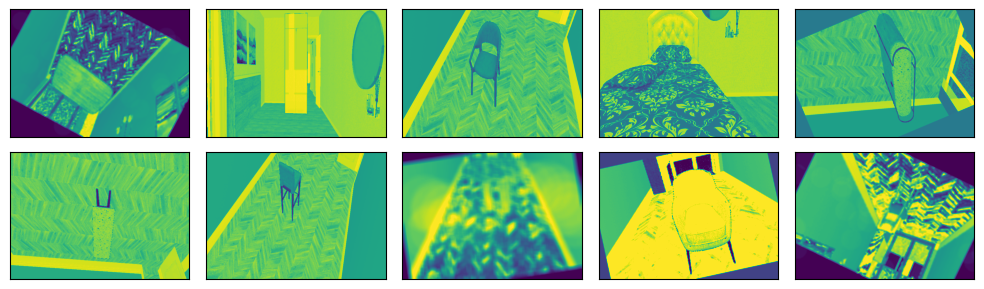

In [7]:
data = BuildDatasetImage(df, PATH_FOR_IMAGE)
fig = plt.figure(figsize=(10, 3))
data = iter(data)
for num, _ in enumerate(range(10)):
    img = next(data)["img_x"][0]
    fig.add_subplot(2, 5, num + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## <a id='toc1_2_'></a>[Обучение модели](#toc0_)

При обучении модели будет применятся фраемворк [lightning](https://lightning.ai/pages/open-source/) (доступ только по прокси).

Использованы предобученные модели resnet разного размера (18, 50, 101). Для каждого класса изображений создана своя 'голова', то есть задача сведена к решению задачи бинарной классификации для каждого датасета. 
С кодом модели, написанной с особенностью lightning, можно ознакомися в файле src/model/ModelLight.py. 

Логика набора данных прописана в файле src/data/Dataset.py. 
В файле просписан загрузчик LitDataLoader.py, адаптированый под lightning.

При обучении модели применяется:
- автоматический подбор размера батча; 
- автоматическое определение размера lr;
- EarlyStopping;
- CyclicLR.


В ходе обучения будет на валидационной выборке считается global_f1, это f1, которая считается f1 для всех предсказаний, где на одно изображение приходится количестов предсказаний равное количеству классов. 
Лучшая итерация модели выбирается по global_accuracy.

Кроме того, в ходе обучения фиксируется общий лосс по валидационному датасету, а также для каждого класса в отдельности: собственный лосс, accuracy, F1.

Для мониторинга процесса обучения применяется [comet.ml](https://www.comet.com)

С метриками, записанными в процессе обучения, можно ознакомится в comet.ml:
- для [resnеt18](https://www.comet.com/gleb01548/tune-resnet/895fb34db1084d4abdf9dcb1758e7502?experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step), где заморожено все, кроме слоя классификатора. 
- для [resnet18](https://www.comet.com/gleb01548/tune-resnet/0842787e8d6c41f697bff1f63d8d8597?experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step); 
- для [resnеt50](https://www.comet.com/gleb01548/tune-resnet/23f7acf9cf1d47c6a8188c6e58593386?experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step), где заморожено все, кроме слоя классификатора. 
- для [resnet50](https://www.comet.com/gleb01548/tune-resnet/ffe22f31919046af8d72cf52b14e1f25?experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step); 
- для [resnеt101](https://www.comet.com/gleb01548/tune-resnet/fb6f046a11df42358a66121a06cb696f?experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step), где заморожено все, кроме слоя классификатора. 
- для [resnet101](https://www.comet.com/gleb01548/tune-resnet/299e1e77c75841329f88ffda76e3fc42?experiment-tab=panels&showOutliers=true&smoothing=0&xAxis=step); 

In [18]:
def train_resnet(resnet_type: str, freeze_layer_resnet: bool):
    datamodule = LitDataLoader(
        train_df,
        valid_df,
        test_df,
        path_to_image=PATH_FOR_IMAGE,
        path_to_test_image=PATH_FOR_TEST_IMAGE,
        num_workers=8,
        resize=None,
        normalize=Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transformer=A.Compose(
            [
                A.Rotate(limit=80, p=0.9, border_mode=cv2.BORDER_CONSTANT),
                A.HorizontalFlip(p=0.6),
                A.VerticalFlip(p=0.5),
                RandomFog(),
                RandomBrightnessContrast(),
            ]
        ),
        tr_chance=0.6,
    )

    model = ModelLight(resnet_type, freeze_layer_resnet)

    checkpoint_callback = ModelCheckpoint(
        monitor="global_f1",
        dirpath="checkpoint",
        filename="checkpoint",
        mode="min",
    )
    lr_logger = LearningRateMonitor(logging_interval="epoch")
    comet_logger = CometLogger(
        project_name="tune_resnet", api_key="ddEXKrGdl7ryYW2YWc6A6mWNd"
    )

    es = EarlyStopping(monitor="val_loss", mode="min", patience=50)

    callbacks = [checkpoint_callback, lr_logger, es]

    trainer = pl.Trainer(
        callbacks=callbacks,
        accelerator="gpu",
        devices=[0],
        max_epochs=120,
        deterministic=True,
        logger=comet_logger,
        log_every_n_steps=1,
    )

    tuner = Tuner(trainer)

    tuner.scale_batch_size(model, datamodule=datamodule, mode="binsearch")

    datamodule.batch_size -= 2

    tuner.lr_find(model, datamodule=datamodule)

    comet_logger.log_hyperparams(
        {
            "batch_size": datamodule.batch_size,
            "lr": model.lr,
            "resnet_name": resnet_type,
        }
    )
    trainer.fit(model, datamodule=datamodule)
    trainer.test(model, datamodule=datamodule)
    if freeze_layer_resnet:
        trainer.save_checkpoint(f"checkpoint/result_{resnet_type}_freeze.ckpt")
    else:
        trainer.save_checkpoint(f"checkpoint/result_{resnet_type}.ckpt")
    return model, trainer

In [9]:
model_resnet18_freeze, trainer_resnet18_freeze = train_resnet("resnet18", True)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-8OSt3Etu-py3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/harddisk/study/cv_Interior_clf/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 suc

Epoch 119: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it, v_num=7502]       

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it, v_num=7502]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/895fb34db1084d4abdf9dcb1758e7502
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     armchair_accuracy [120] : (0.7064676880836487, 0.9154228568077087)
COMET INFO:     armchair_f1 [120]       : (0.0, 0.84112149477005)
COMET INFO:     armchair_loss [120]     : (0.29078561067581177, 0.6450952887535095)
COMET INFO:     bed_accuracy [120]      : (0.39303481578826904, 0.9950248599052429)
COMET INFO:     bed_f1 [120]            : (0.0, 0.9873417615890503)
COMET INFO:     bed_loss [120]          : (0.03297503665089607, 0.7076305150985718)
COMET INFO:     chair_accuracy [120]    : (0.646766185760498, 0.910447

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/895fb34db1084d4abdf9dcb1758e7502
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     lr          : True
COMET INFO:     resnet_type : resnet18
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [10]:
model_resnet18, trainer_resnet18 = train_resnet("resnet18", False)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-8OSt3Etu-py3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/harddisk/study/cv_Interior_clf/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 suc

Epoch 119: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, v_num=8597]       

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, v_num=8597]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/0842787e8d6c41f697bff1f63d8d8597
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     armchair_accuracy [120] : (0.711442768573761, 0.9353233575820923)
COMET INFO:     armchair_f1 [120]       : (0.0, 0.8849557638168335)
COMET INFO:     armchair_loss [120]     : (0.25367268919944763, 0.6043320298194885)
COMET INFO:     bed_accuracy [120]      : (0.2537313401699066, 0.9950248599052429)
COMET INFO:     bed_f1 [120]            : (0.0, 0.9876543283462524)
COMET INFO:     bed_loss [120]          : (0.03864748403429985, 0.738273024559021)
COMET INFO:     chair_accuracy [120]    : (0.606965184211731, 0.9154228

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/0842787e8d6c41f697bff1f63d8d8597
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     lr          : False
COMET INFO:     resnet_type : resnet18
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [13]:
model_resnet50_freeze, trainer_resnet50_freeze = train_resnet("resnet50", True)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying batch size 64
Batch size 64 failed, trying batch size 48
Batch size 48 failed, trying batch size 40
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 40 succeeded, trying batch size 44
Batch size 44 failed, trying batch size 42
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 42 succeeded, trying bat

Epoch 119: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s, v_num=3386]     

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s, v_num=3386]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/23f7acf9cf1d47c6a8188c6e58593386
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     armchair_accuracy [120] : (0.6865671873092651, 0.9004974961280823)
COMET INFO:     armchair_f1 [120]       : (0.0, 0.8113207817077637)
COMET INFO:     armchair_loss [120]     : (0.31064948439598083, 0.6508336067199707)
COMET INFO:     bed_accuracy [120]      : (0.8009950518608093, 0.9900497794151306)
COMET INFO:     bed_f1 [120]            : (0.0, 0.9750000238418579)
COMET INFO:     bed_loss [120]          : (0.039217062294483185, 0.586603581905365)
COMET INFO:     chair_accuracy [120]    : (0.646766185760498, 0.92039

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/23f7acf9cf1d47c6a8188c6e58593386
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     lr          : True
COMET INFO:     resnet_type : resnet50
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [14]:
model_resnet50, trainer_resnet50 = train_resnet("resnet50", False)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-8OSt3Etu-py3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/harddisk/study/cv_Interior_clf/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 suc

Epoch 119: 100%|██████████| 21/21 [00:12<00:00,  1.70it/s, v_num=1f25]     

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 21/21 [00:12<00:00,  1.70it/s, v_num=1f25]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/ffe22f31919046af8d72cf52b14e1f25
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     armchair_accuracy [120] : (0.7164179086685181, 0.8905472755432129)
COMET INFO:     armchair_f1 [120]       : (0.0, 0.792792797088623)
COMET INFO:     armchair_loss [120]     : (0.3143308162689209, 0.6264291405677795)
COMET INFO:     bed_accuracy [120]      : (0.8009950518608093, 0.9950248599052429)
COMET INFO:     bed_f1 [120]            : (0.0, 0.9876543283462524)
COMET INFO:     bed_loss [120]          : (0.03087247535586357, 0.6314077973365784)
COMET INFO:     chair_accuracy [120]    : (0.646766185760498, 0.9353233

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/ffe22f31919046af8d72cf52b14e1f25
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     lr          : False
COMET INFO:     resnet_type : resnet50
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [19]:
model_resnet101_freeze, trainer_resnet101_freeze = train_resnet("resnet101", True)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-8OSt3Etu-py3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/harddisk/study/cv_Interior_clf/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
Batch size 32 failed, trying batch size 24
`Trainer.fit` stoppe

Epoch 108: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s, v_num=696f]     


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/fb6f046a11df42358a66121a06cb696f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     armchair_accuracy [109] : (0.28358209133148193, 0.93034827709198)
COMET INFO:     armchair_f1 [109]       : (0.4166666567325592, 0.8771929740905762)
COMET INFO:     armchair_loss [109]     : (0.2843021750450134, 2.785660982131958)
COMET INFO:     bed_accuracy [109]      : (0.8009950518608093, 0.9900497794151306)
COMET INFO:     bed_f1 [109]            : (0.0, 0.9750000238418579)
COMET INFO:     bed_loss [109]          : (0.044636551290750504, 2.250981092453003)
COMET INFO:     chair_accuracy [109]    : (0.646766185760

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/fb6f046a11df42358a66121a06cb696f
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     lr          : True
COMET INFO:     resnet_type : resnet101
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [20]:
model_resnet101, trainer_resnet101 = train_resnet("resnet101", False)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gleb/.cache/pypoetry/virtualenvs/mlposproj-8OSt3Etu-py3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/harddisk/study/cv_Interior_clf/checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
Batch size 32 failed, trying batch size 24
`Trainer.fit` stoppe

Epoch 103: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s, v_num=fc42]     


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/299e1e77c75841329f88ffda76e3fc42
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     armchair_accuracy [104] : (0.28358209133148193, 0.9154228568077087)
COMET INFO:     armchair_f1 [104]       : (0.22535210847854614, 0.8468468189239502)
COMET INFO:     armchair_loss [104]     : (0.30037832260131836, 2.799391984939575)
COMET INFO:     bed_accuracy [104]      : (0.5522388219833374, 0.9950248599052429)
COMET INFO:     bed_f1 [104]            : (0.0, 0.9876543283462524)
COMET INFO:     bed_loss [104]          : (0.044794898480176926, 2.6487069129943848)
COMET INFO:     chair_accuracy [104]    : (0.6417910

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/gleb01548/tune-resnet/299e1e77c75841329f88ffda76e3fc42
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     lr          : False
COMET INFO:     resnet_type : resnet101
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


Лучшая модель это resnet50 без заморозки с результатам f1 0.885 на валидационных данных.

## <a id='toc1_3_'></a>[Работа модели на реальных данных](#toc0_)

In [83]:
model_resnet50.test_metrics

{'val_loss': tensor(5.2509),
 'sofa_loss': tensor(1.2970),
 'sofa_accuracy': tensor(0.6000),
 'sofa_f1': tensor(0.4231),
 'wardrobe_loss': tensor(0.5730),
 'wardrobe_accuracy': tensor(0.8000),
 'wardrobe_f1': tensor(0.5161),
 'chair_loss': tensor(0.9534),
 'chair_accuracy': tensor(0.6667),
 'chair_f1': tensor(0.1935),
 'armchair_loss': tensor(0.6433),
 'armchair_accuracy': tensor(0.7867),
 'armchair_f1': tensor(0.5294),
 'table_loss': tensor(0.5833),
 'table_accuracy': tensor(0.7467),
 'table_f1': tensor(0.6275),
 'commode_loss': tensor(0.7991),
 'commode_accuracy': tensor(0.7200),
 'commode_f1': tensor(0.4615),
 'bed_loss': tensor(0.4018),
 'bed_accuracy': tensor(0.8533),
 'bed_f1': tensor(0.4762),
 'global_accuracy': tensor(0.7390),
 'global_f1': tensor(0.4710)}

In [49]:
predict = model_resnet50.predict_test
target = model_resnet50.target_test


In [74]:
def show_error_image(error_list):    
    fig = plt.figure(figsize=(10, 10))
    for num, index in enumerate(error_list):
        img = Image.open(os.path.join(PATH_FOR_TEST_IMAGE, str(index) + '.jpg'))
        fig.add_subplot(6, 6, num + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [75]:
def errors(key):
    fp = []
    fn = []

    predict_list = predict[key]
    target_list = target[key]

    for index, value in enumerate(predict_list):
        if value and not target_list[index]:
            fp.append(index)

        if not value and target_list[index]:
            fn.append(index)
    
    if not len(fp):
        print('FP нет')
    else:
        print('FP')
        show_error_image(fp)
    
    if not len(fn):
        print('FN нет')
    else:
        print('FN')
        show_error_image(fn)

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


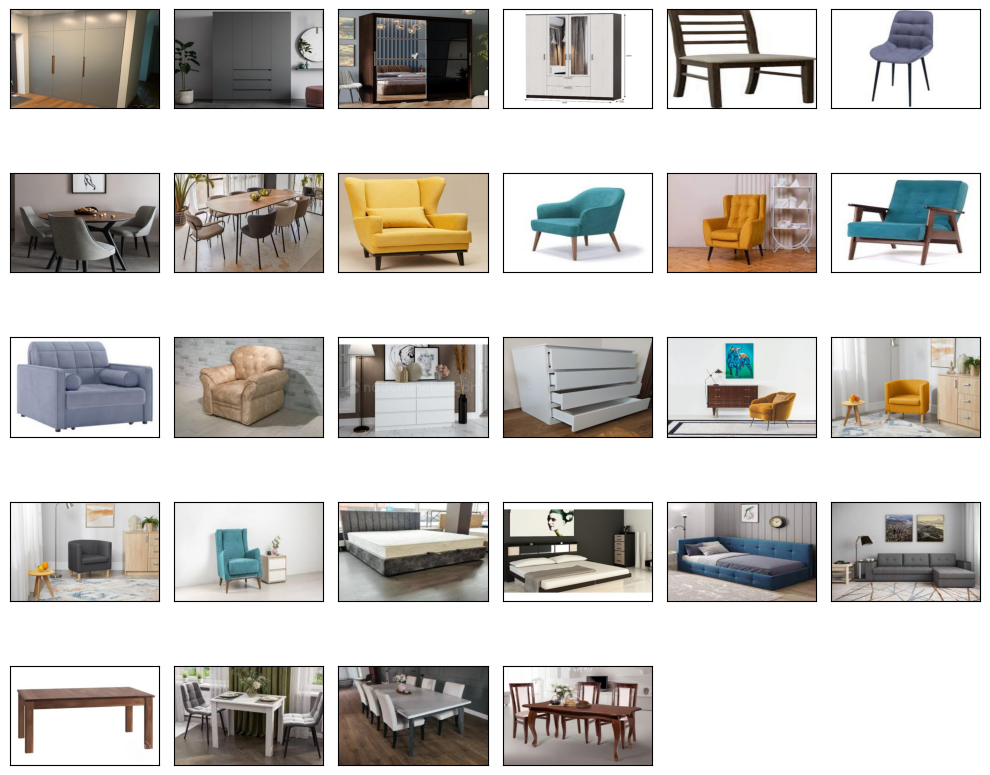

FN


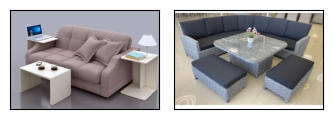

In [76]:
errors('sofa')

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


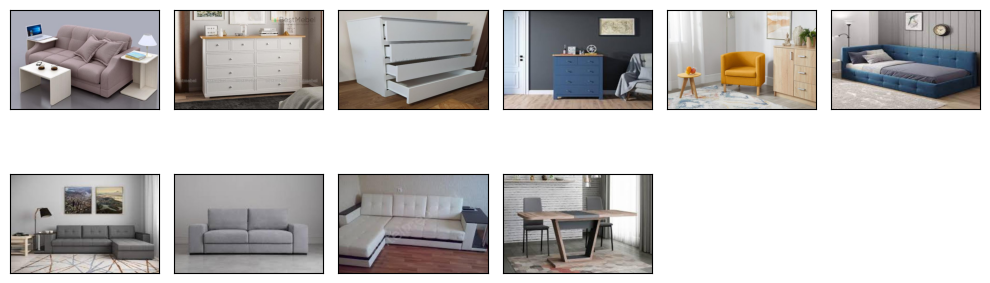

FN


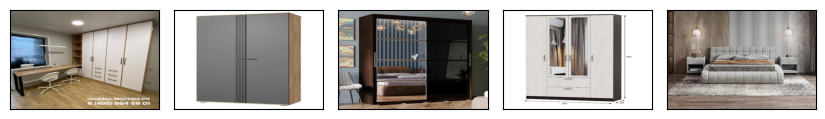

In [77]:
errors('wardrobe')

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


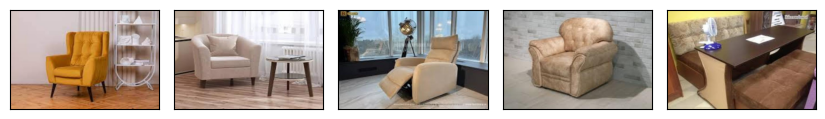

FN


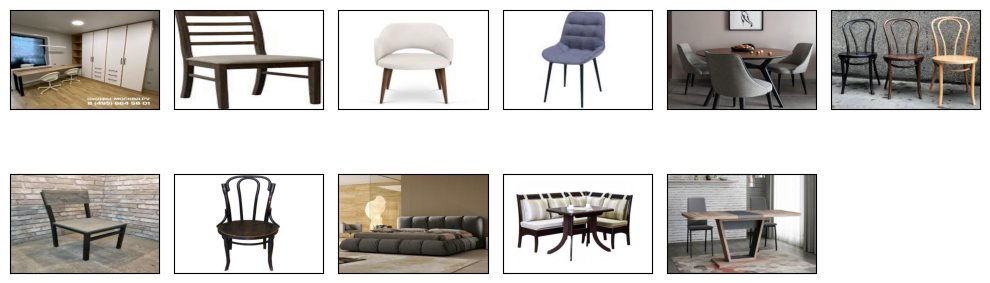

In [78]:
errors('armchair')

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


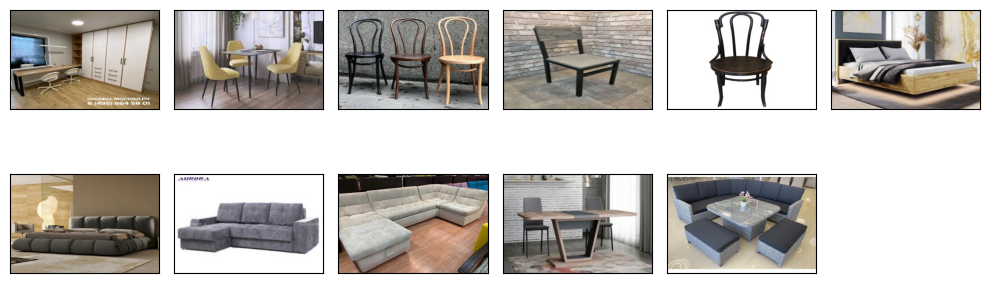

FN


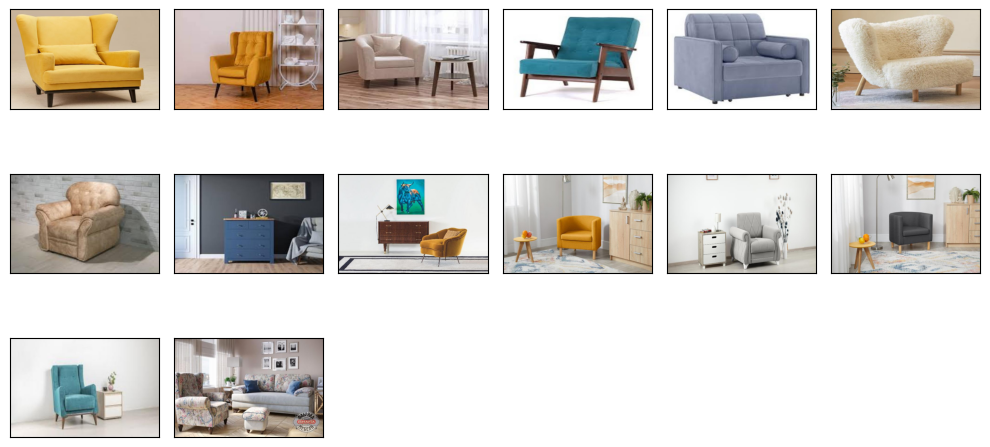

In [79]:
errors('chair')

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


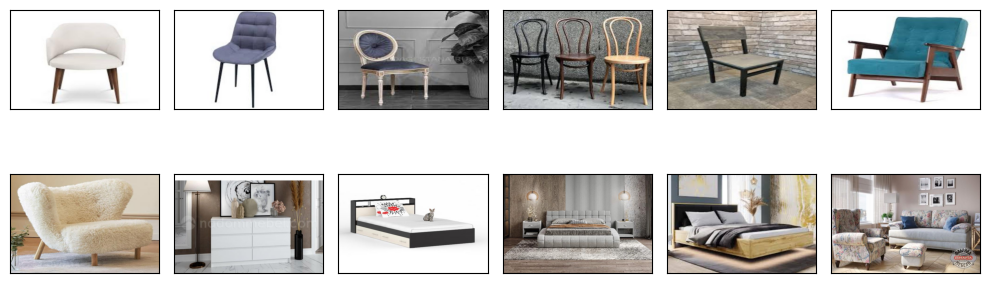

FN


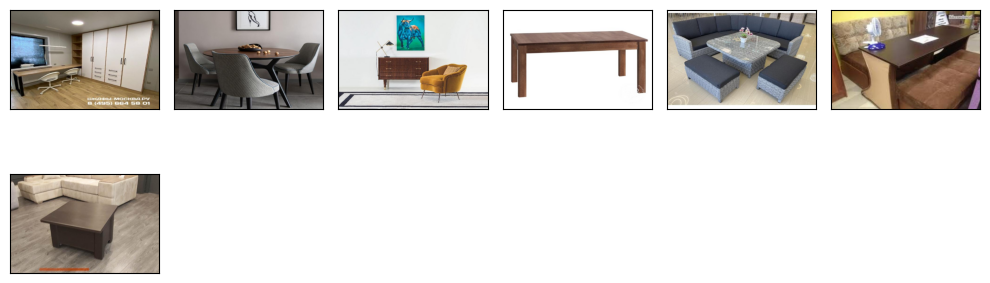

In [80]:
errors('table')

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


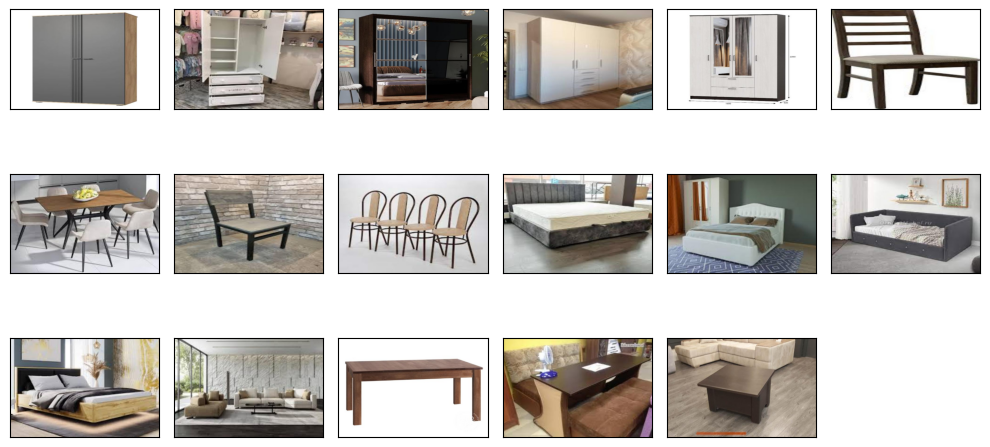

FN


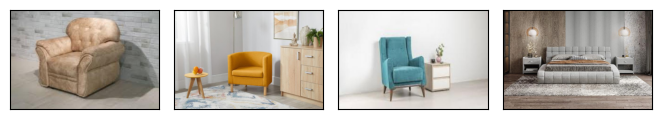

In [81]:
errors('commode')

FP


/tmp/ipykernel_1423074/1292053440.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


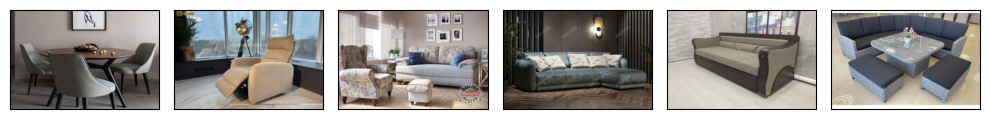

FN


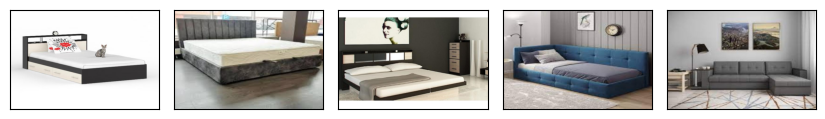

In [82]:
errors('bed')

Как видно модель не очень хорошо справляется с классификаций изображений на реальных данных f1 всего 0.471.

Сама модель особенно плохо справляется с определением диванов. Она принимает за них, по сути, любой широкий в кадр объект. Также плохо разделяет стулья и кресла. 

Полагаю, что это связано с большой вариативностью мебели и малым датасетом для обучения.

## <a id='toc1_4_'></a>[Вывод](#toc0_)

В ходе работы дообучено 6 моделей для классификации изображения на предмет наличия мебели на изображениях.

Дообучение и валидация проходила на синтетических данных.

Это модели resnet18, resnet50, resnet101, как с заморозкой основной модели (обучался только слой классификации) так и без нее. 

Лучше всего на валидационных данных себя показала модель resnet50 без заморозки слоев и метрикой f1 0.885. 

Однако на реальных данных модель показала себя плохо - метрика f1 0.471. Модель особенно плохо справляется с определением диванов. Она принимает за них, по сути, любой широкий в кадру объект. Также плохо разделяет стулья и кресла. 

Полагаю, что это связано с большой вариативностью мебели и малым датасетом для обучения.